In [2]:
# 필요한 라이브러리 설치
!pip install kaggle --quiet
!pip install torch torchvision albumentations --quiet

# Kaggle API Key 업로드 (이 코드 실행 후, 파일 업로드 필요)
from google.colab import files
files.upload()

# Kaggle 데이터 다운로드 및 압축 해제
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip -q lgg-mri-segmentation.zip -d data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.6/307.6 kB 23.4 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 97% 696M/714M [00:02<00:00, 292MB/s]
100% 714M/714M [00:02<00:00, 263MB/s]


In [3]:
import os

IMAGE_DIR = "data/lgg-mri-segmentation/kaggle_3m"

# 모든 .tif 파일을 찾기 위해 하위 폴더까지 탐색
image_paths = []
mask_paths = []

for folder in os.listdir(IMAGE_DIR):
    folder_path = os.path.join(IMAGE_DIR, folder)

    if os.path.isdir(folder_path):  # 폴더라면?
        for file in os.listdir(folder_path):  # 폴더 안의 파일 리스트 가져오기
            file_path = os.path.join(folder_path, file)

            if file.lower().endswith(".tif"):  # tif 파일만 필터링
                if "mask" in file.lower():
                    mask_paths.append(file_path)
                else:
                    image_paths.append(file_path)

# 정렬 (파일 순서 유지)
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

print(f"총 이미지 개수: {len(image_paths)}")
print(f"총 마스크 개수: {len(mask_paths)}")

# 예외 처리: 데이터가 없으면 오류 발생
if len(image_paths) == 0 or len(mask_paths) == 0:
    raise ValueError("데이터셋이 비어 있습니다.")


총 이미지 개수: 3929
총 마스크 개수: 3929


In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2

# 데이터 경로
IMAGE_DIR = "data/lgg-mri-segmentation/kaggle_3m"
MASK_DIR = "data/lgg-mri-segmentation/kaggle_3m"

# 모든 .tif 파일을 찾기 위해 하위 폴더까지 탐색
image_paths = []
mask_paths = []

for folder in os.listdir(IMAGE_DIR):
    folder_path = os.path.join(IMAGE_DIR, folder)

    if os.path.isdir(folder_path):  # 폴더라면?
        for file in os.listdir(folder_path):  # 폴더 안의 파일 리스트 가져오기
            file_path = os.path.join(folder_path, file)

            if file.lower().endswith(".tif"):  # tif 파일만 필터링
                if "mask" in file.lower():
                    mask_paths.append(file_path)
                else:
                    image_paths.append(file_path)

# 정렬
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

# 데이터셋 클래스 정의
class BrainMRIDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)  # 흑백 로드
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # 크기 변경 (256x256)
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # 정규화 및 변환
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask

# 데이터 변환 정의
transform = A.Compose([
    A.Normalize(mean=0.5, std=0.5),
    ToTensorV2()
])

# 데이터셋 및 DataLoader 생성
train_size = int(0.8 * len(image_paths))
train_dataset = BrainMRIDataset(image_paths[:train_size], mask_paths[:train_size], transform)
val_dataset = BrainMRIDataset(image_paths[train_size:], mask_paths[train_size:], transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Conv 블록 정의
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Encoder (특징을 추출)
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2) # 풀링

        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2) # 풀링

        # Bottleneck (핵심 정보)
        self.bottleneck = conv_block(128, 256)

        # Decoder (특징을 다시 원본 크기로 복원)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)  # skip connection으로 채널이 합쳐짐 (128+128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)  # skip connection (64+64)

        # 최종 출력
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder 과정
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))

        # 병목 구간
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Decoder 과정 (업샘플링 + 스킵 연결)
        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((enc2, dec2), dim=1)  # 스킵 연결
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)  # 스킵 연결
        dec1 = self.dec1(dec1)

        return self.final_conv(dec1)  # sigmoid는 사용 X (손실 함수를 위해 logits로 반환해야 함)

model = UNet()


In [17]:
import torch_xla
import torch_xla.core.xla_model as xm

device = xm.xla_device()
print("TPU 디바이스 확인:", device)


TPU 디바이스 확인: xla:0


In [18]:
# 위에서 제공한 정확한 UNet 모델 클래스 정의
model = UNet(in_channels=1, out_channels=1)

# 모델 TPU로 이동
model = model.to(device)
print("모델 TPU 이동 완료")


모델 TPU 이동 완료


In [19]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

print("criterion, optimizer 설정 완료")

criterion, optimizer 설정 완료


In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

images, masks = next(iter(train_loader))
print(f"로딩된 이미지 shape: {images.shape}")
print(f"로딩된 마스크 shape: {masks.shape}")

로딩된 이미지 shape: torch.Size([4, 1, 256, 256])
로딩된 마스크 shape: torch.Size([4, 256, 256])


In [22]:
#정규화 확인
def to_xla(tensor):
    return tensor.to(device, dtype=torch.float32)

images_xla = to_xla(images)
masks_xla = to_xla(masks).unsqueeze(1) / 255.0  # 마스크 반드시 정규화(0~1)

print(f"images_xla 텐서 디바이스: {images_xla.device}, dtype: {images_xla.dtype}")
print(f"masks_xla 텐서 디바이스: {masks_xla.device}, 값 범위: {masks_xla.min().item()}~{masks_xla.max().item()}")


images_xla 텐서 디바이스: xla:0, dtype: torch.float32
masks_xla 텐서 디바이스: xla:0, 값 범위: 0.0~0.9999999403953552


In [23]:
loss = criterion(outputs, masks_xla)
print(f"loss 계산 테스트 결과: {loss.item()}")


loss 계산 테스트 결과: 1.298279047012329


In [25]:
num_epochs = 1  # 테스트로 한 번만 실행
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = to_xla(images)
        masks = to_xla(masks).unsqueeze(1) / 255.0

        optimizer.zero_grad()
        outputs = model(images)  # sigmoid 제거
        loss = criterion(outputs, masks)
        loss.backward()
        xm.optimizer_step(optimizer, barrier=True)

        epoch_loss += loss.item()

    xm.mark_step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/1], Loss: 36.5983


In [26]:
model.train()
optimizer.zero_grad()

images, masks = next(iter(train_loader))

# TPU 디바이스 및 정규화 재확인
images_xla = to_xla(images)
masks_xla = to_xla(masks).unsqueeze(1) / 255.0

# 모델 출력 확인
outputs = model(images_xla)

# 출력값의 범위를 확인하여 logits가 정상적인 범위에 있는지 체크
print("출력 logits 값 범위:", outputs.min().item(), "~", outputs.max().item())

# loss 값 확인
criterion = torch.nn.BCEWithLogitsLoss()
loss = criterion(outputs, masks_xla)
print("loss 값 확인:", loss.item())

# backward 동작 확인
loss.backward()

# optimizer 동작 확인
xm.optimizer_step(optimizer, barrier=True)

# TPU 동기화 작업
xm.mark_step()

출력 logits 값 범위: -11.514328002929688 ~ -0.901167094707489
loss 값 확인: 0.03950488567352295


In [27]:
num_epochs = 1  # 일단 테스트로 한 번만
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batch_idx = 0

    for images, masks in train_loader:
        images = to_xla(images)
        masks = to_xla(masks).unsqueeze(1) / 255.0  # 반드시 0~1 정규화

        optimizer.zero_grad()
        outputs = model(images)  # sigmoid 제거!!
        loss = criterion(outputs, masks)
        loss.backward()
        xm.optimizer_step(optimizer, barrier=True)

        epoch_loss += loss.item()
        batch_idx += 1
        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}, 손실: {loss.item():.4f}")

    xm.mark_step()
    print(f"Epoch [{epoch+1}], 평균 Loss: {epoch_loss / len(train_loader):.4f}")


Batch 50, 손실: 0.0133
Batch 100, 손실: 0.0305
Batch 150, 손실: 0.1255
Batch 200, 손실: 0.1833
Batch 250, 손실: 0.0355
Batch 300, 손실: 0.0593
Batch 350, 손실: 0.0578
Batch 400, 손실: 0.0441
Batch 450, 손실: 0.0498
Batch 500, 손실: 0.0438
Batch 550, 손실: 0.1503
Batch 600, 손실: 0.0817
Batch 650, 손실: 0.0265
Batch 700, 손실: 0.0216
Batch 750, 손실: 0.0244
Epoch [1], 평균 Loss: 0.0426


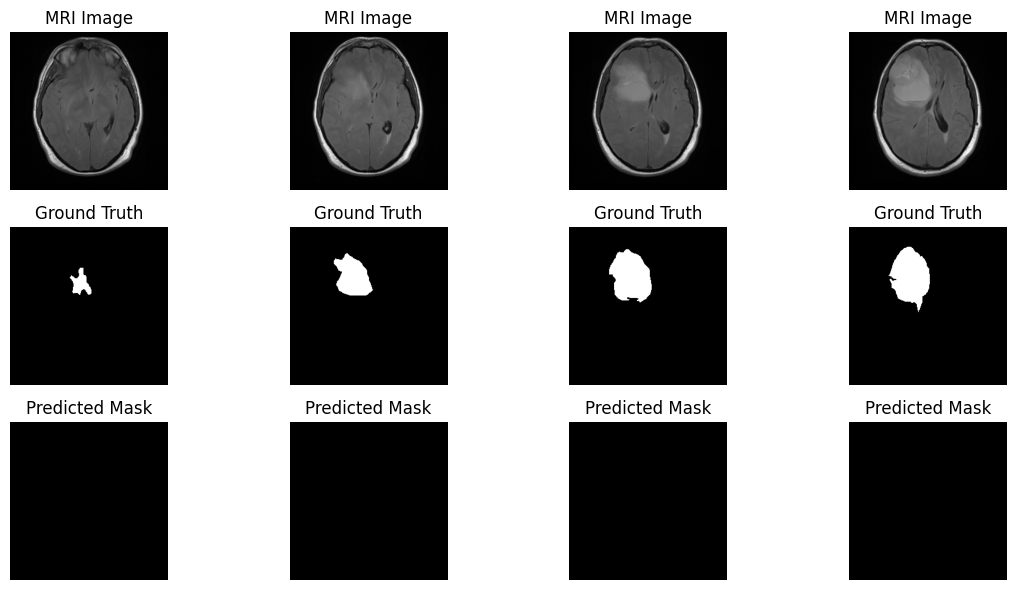

In [28]:
model.eval()
with torch.no_grad():
    sample_img, sample_mask = next(iter(val_loader))
    sample_img_xla = to_xla(sample_img)
    pred_mask = torch.sigmoid(model(sample_img_xla)).cpu().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.imshow(sample_img[i][0], cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(3, 4, i+5)
    plt.imshow(sample_mask[i], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3, 4, i+9)
    plt.imshow(pred_mask[i][0] > 0.5, cmap="gray")  # 0.5 기준 이진화
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [30]:
sample_masks = masks_xla.cpu().numpy()
print("마스크의 고유값 확인:", np.unique(sample_mask.cpu().numpy()))

마스크의 고유값 확인: [  0 255]


In [31]:
pos_weight = torch.tensor([10.0]).to(device)

# 클래스 불균형을 고려한 손실 함수 정의
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 모델 학습 코드
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device, dtype=torch.float32)
        masks = (masks / 255).unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()

        xm.optimizer_step(optimizer, barrier=True)

        epoch_loss += loss.item()

    xm.mark_step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/1], Loss: 172.1205


sigmoid 예측값의 최소값: 6.0856342e-05
sigmoid 이후 예측값 최대치: 0.7432679


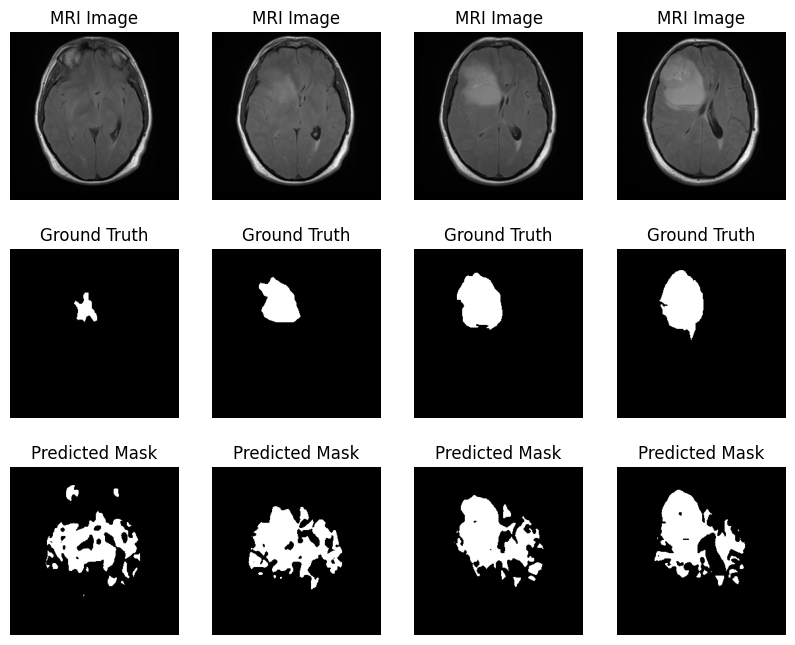

In [32]:
# 시각화
model.eval()
with torch.no_grad():
    sample_img, sample_mask = next(iter(val_loader))

    sample_img = to_xla(sample_img)
    pred_mask_logits = model(sample_img)
    pred_mask = torch.sigmoid(pred_mask_logits).cpu().numpy()

# sigmoid 이후
print("sigmoid 예측값의 최소값:", pred_mask.min())
print("sigmoid 이후 예측값 최대치:", pred_mask.max())

# 예측된 마스크와 Ground Truth 시각화로 직접 확인
plt.figure(figsize=(10, 8))

for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_img[i][0].cpu(), cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(3, 4, i + 5)
    plt.imshow(sample_mask[i].cpu(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3, 4, i + 9)
    plt.imshow(pred_mask[i][0] > 0.5, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.show()

 pos_weight를 너무 높게 설정했나?

In [33]:
pos_weight = torch.tensor([3.8]).to(device)

# 클래스 불균형을 고려한 손실 함수 정의
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 모델 학습 코드
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device, dtype=torch.float32)
        masks = (masks / 255).unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()

        xm.optimizer_step(optimizer, barrier=True)

        epoch_loss += loss.item()

    xm.mark_step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/1], Loss: 87.7564


sigmoid 예측값의 최소값: 2.771616e-06
sigmoid 이후 예측값 최대치: 0.68279576


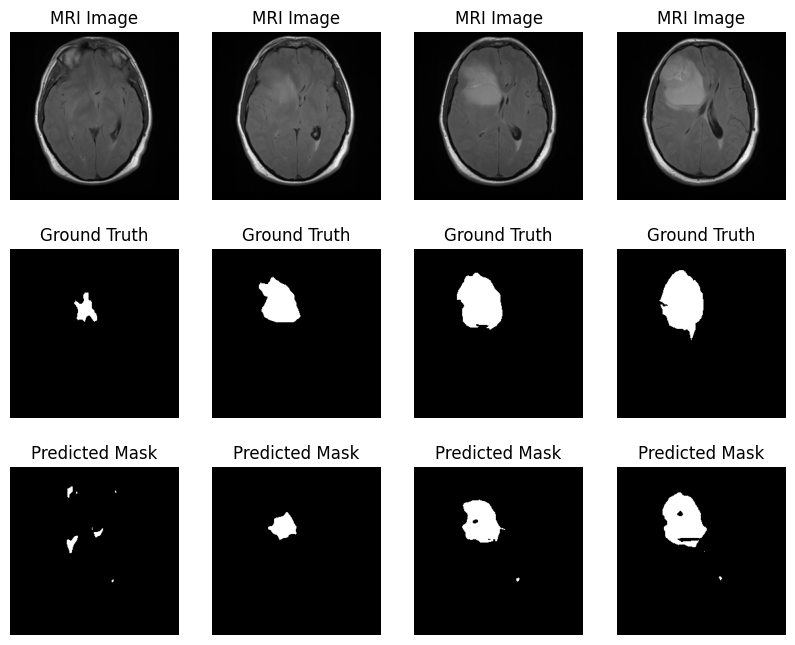

In [34]:
model.eval()
with torch.no_grad():
    sample_img, sample_mask = next(iter(val_loader))

    sample_img = to_xla(sample_img)
    pred_mask_logits = model(sample_img)
    pred_mask = torch.sigmoid(pred_mask_logits).cpu().numpy()

# sigmoid 이후
print("sigmoid 예측값의 최소값:", pred_mask.min())
print("sigmoid 이후 예측값 최대치:", pred_mask.max())

# 예측된 마스크와 Ground Truth 시각화로 직접 확인
plt.figure(figsize=(10, 8))

for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_img[i][0].cpu(), cmap="gray")
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(3, 4, i + 5)
    plt.imshow(sample_mask[i].cpu(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3, 4, i + 9)
    plt.imshow(pred_mask[i][0] > 0.5, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.show()